<a href="https://colab.research.google.com/github/aniketSanyal/OverfittingInRML/blob/main/rml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define Models for CIFAR10 and MNIST

In [2]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Define FGSM and PGD Attack Functions

In [3]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def pgd_attack(model, image, label, epsilon, alpha, iters, device):
    # Initialize perturbation as zero
    perturbation = torch.zeros_like(image).to(device)
    perturbation.requires_grad = True

    for _ in range(iters):
        outputs = model(image + perturbation)
        loss = F.cross_entropy(outputs, label)
        model.zero_grad()
        loss.backward()

        # Update the perturbation
        perturbation.data += alpha * perturbation.grad.data.sign()
        perturbation.data = torch.clamp(perturbation.data, -epsilon, epsilon)

    # Apply the perturbation and clip the result
    perturbed_image = torch.clamp(image + perturbation, 0, 1)
    return perturbed_image


# Load Data for Both Datasets

In [4]:
# Transformations for CIFAR10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing for CIFAR10
])

# Transformations for MNIST
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing for MNIST
])

# CIFAR10
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

# MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

# Data loaders with batch processing
batch_size = 64  # You can adjust the batch size

cifar_train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 46922840.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


100%|██████████| 9912422/9912422 [00:00<00:00, 145026323.16it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 109328243.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35206663.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21526021.21it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Training and Testing Functions

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total predictions counter

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        total += target.size(0)  # Accumulate total

        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = F.cross_entropy(output, target)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()
        pred = output.argmax(dim=1)  # Get the index of the max log-probability
        correct += pred.eq(target).sum().item()  # Accumulate correct predictions

    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total  # Calculate accuracy
    return average_loss, accuracy

def test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients for testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            total += target.size(0)

            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total  # Calculate accuracy
    return test_loss, accuracy

def train_adversarial(model, device, train_loader, optimizer, epoch, attack, epsilon, alpha=None, iters=None):
    model.train()
    total_loss = 0
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total predictions counter

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        total += target.size(0)  # Accumulate total predictions

        # Generate adversarial examples
        if attack == fgsm_attack:
            data.requires_grad = True
            output = model(data)
            loss = F.cross_entropy(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            adversarial_data = fgsm_attack(data, epsilon, data_grad)
        elif attack == pgd_attack and alpha is not None and iters is not None:
            adversarial_data = pgd_attack(model, data, target, epsilon, alpha, iters, device)
        else:
            raise ValueError("Invalid attack method or missing parameters for PGD")

        # Training step with adversarial examples
        optimizer.zero_grad()
        output = model(adversarial_data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)  # Get the index of the max log-probability
        correct += pred.eq(target).sum().item()  # Accumulate correct predictions

    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total  # Calculate accuracy
    return average_loss, accuracy

def test_adversarial(model, device, test_loader, attack, epsilon, alpha=None, iters=None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        total += target.size(0)

        # Set requires_grad to True for attack generation
        data.requires_grad = True

        # Forward pass
        output = model(data)
        loss = F.cross_entropy(output, target)

        # If attack is FGSM, generate adversarial example
        if attack == fgsm_attack:
            model.zero_grad()
            loss.backward()
            data_grad = data.grad
            adversarial_data = fgsm_attack(data, epsilon, data_grad)
        elif attack == pgd_attack and alpha is not None and iters is not None:
            adversarial_data = pgd_attack(model, data, target, epsilon, alpha, iters, device)
        else:
            raise ValueError("Invalid attack method or missing parameters for PGD")

        # Evaluate on adversarial examples
        output = model(adversarial_data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / total  # Calculate accuracy
    return test_loss, accuracy


# Training and Testing with Adversarial Attacks

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize CIFAR10 and MNIST models
model_cifar = CIFAR10_CNN().to(device)
model_mnist = MNIST_CNN().to(device)

# Define optimizers for each model
optimizer_cifar = torch.optim.Adam(model_cifar.parameters(), lr=0.001)
optimizer_mnist = torch.optim.Adam(model_mnist.parameters(), lr=0.001)

num_epochs = 10  # Define the number of epochs
# Set parameters for attacks
epsilon = 0.1  # Perturbation magnitude for FGSM
alpha = 0.01   # Step size for PGD
iters = 40     # Number of iterations for PGD

train_accuracies_cifar, test_accuracies_cifar = [], []
train_accuracies_mnist, test_accuracies_mnist = [], []
train_accuracies_cifar_adv, test_accuracies_cifar_adv = [], []
train_accuracies_mnist_adv, test_accuracies_mnist_adv = [], []
train_accuracies_cifar_pgd, test_accuracies_cifar_pgd = [], []
train_accuracies_mnist_pgd, test_accuracies_mnist_pgd = [], []
train_losses_cifar, test_losses_cifar = [], []
train_losses_mnist, test_losses_mnist = [], []
train_losses_cifar_adv, test_losses_cifar_adv = [], []
train_losses_mnist_adv, test_losses_mnist_adv = [], []
train_losses_cifar_pgd, test_losses_cifar_pgd = [], []
train_losses_mnist_pgd, test_losses_mnist_pgd = [], []

for epoch in range(num_epochs):
    # CIFAR10: 原始数据训练
    train_loss_cifar, train_accuracy_cifar = train(model_cifar, device, cifar_train_loader, optimizer_cifar, epoch)
    train_losses_cifar.append(train_loss_cifar)
    train_accuracies_cifar.append(train_accuracy_cifar)

    # CIFAR10: FGSM对抗性训练
    train_loss_cifar_adv, train_accuracy_cifar_adv = train_adversarial(model_cifar, device, cifar_train_loader, optimizer_cifar, epoch, fgsm_attack, epsilon)
    train_losses_cifar_adv.append(train_loss_cifar_adv)
    train_accuracies_cifar_adv.append(train_accuracy_cifar_adv)

    # CIFAR10: PGD对抗性训练
    train_loss_cifar_pgd, train_accuracy_cifar_pgd = train_adversarial(model_cifar, device, cifar_train_loader, optimizer_cifar, epoch, pgd_attack, epsilon, alpha, iters)
    train_losses_cifar_pgd.append(train_loss_cifar_pgd)
    train_accuracies_cifar_pgd.append(train_accuracy_cifar_pgd)

    # MNIST: 原始数据训练
    train_loss_mnist, train_accuracy_mnist = train(model_mnist, device, mnist_train_loader, optimizer_mnist, epoch)
    train_losses_mnist.append(train_loss_mnist)
    train_accuracies_mnist.append(train_accuracy_mnist)

    # MNIST: FGSM对抗性训练
    train_loss_mnist_adv, train_accuracy_mnist_adv = train_adversarial(model_mnist, device, mnist_train_loader, optimizer_mnist, epoch, fgsm_attack, epsilon)
    train_losses_mnist_adv.append(train_loss_mnist_adv)
    train_accuracies_mnist_adv.append(train_accuracy_mnist_adv)

    # MNIST: PGD对抗性训练
    train_loss_mnist_pgd, train_accuracy_mnist_pgd = train_adversarial(model_mnist, device, mnist_train_loader, optimizer_mnist, epoch, pgd_attack, epsilon, alpha, iters)
    train_losses_mnist_pgd.append(train_loss_mnist_pgd)
    train_accuracies_mnist_pgd.append(train_accuracy_mnist_pgd)

    # 在每个epoch结束后对干净数据进行测试
    test_loss_cifar, test_accuracy_cifar = test(model_cifar, device, cifar_test_loader)
    test_losses_cifar.append(test_loss_cifar)
    test_accuracies_cifar.append(test_accuracy_cifar)

    test_loss_mnist, test_accuracy_mnist = test(model_mnist, device, mnist_test_loader)
    test_losses_mnist.append(test_loss_mnist)
    test_accuracies_mnist.append(test_accuracy_mnist)

    # 在每个epoch结束后对经过FGSM攻击的数据进行测试
    test_loss_cifar_adv, test_accuracy_cifar_adv = test_adversarial(model_cifar, device, cifar_test_loader, fgsm_attack, epsilon)
    test_losses_cifar_adv.append(test_loss_cifar_adv)
    test_accuracies_cifar_adv.append(test_accuracy_cifar_adv)

    test_loss_mnist_adv, test_accuracy_mnist_adv = test_adversarial(model_mnist, device, mnist_test_loader, fgsm_attack, epsilon)
    test_losses_mnist_adv.append(test_loss_mnist_adv)
    test_accuracies_mnist_adv.append(test_accuracy_mnist_adv)

    # 在每个epoch结束后对经过PGD攻击的数据进行测试
    test_loss_cifar_pgd, test_accuracy_cifar_pgd = test_adversarial(model_cifar, device, cifar_test_loader, pgd_attack, epsilon, alpha, iters)
    test_losses_cifar_pgd.append(test_loss_cifar_pgd)
    test_accuracies_cifar_pgd.append(test_accuracy_cifar_pgd)

    test_loss_mnist_pgd, test_accuracy_mnist_pgd = test_adversarial(model_mnist, device, mnist_test_loader, pgd_attack, epsilon, alpha, iters)
    test_losses_mnist_pgd.append(test_loss_mnist_pgd)
    test_accuracies_mnist_pgd.append(test_accuracy_mnist_pgd)

    # 打印信息
    print(f'Epoch {epoch}:')
    print(f'CIFAR10 - Clean Train Loss: {train_loss_cifar:.4f}, Accuracy: {train_accuracy_cifar:.2f}%')
    print(f'CIFAR10 - FGSM Train Loss: {train_loss_cifar_adv:.4f}, Accuracy: {train_accuracy_cifar_adv:.2f}%')
    print(f'CIFAR10 - PGD Train Loss: {train_loss_cifar_pgd:.4f}, Accuracy: {train_accuracy_cifar_pgd:.2f}%')
    print(f'MNIST - Clean Train Loss: {train_loss_mnist:.4f}, Accuracy: {train_accuracy_mnist:.2f}%')
    print(f'MNIST - FGSM Train Loss: {train_loss_mnist_adv:.4f}, Accuracy: {train_accuracy_mnist_adv:.2f}%')
    print(f'MNIST - PGD Train Loss: {train_loss_mnist_pgd:.4f}, Accuracy: {train_accuracy_mnist_pgd:.2f}%')
    print(f'CIFAR10 - Clean Test Loss: {test_loss_cifar:.4f}, Accuracy: {test_accuracy_cifar:.2f}%')
    print(f'CIFAR10 - FGSM Test Loss: {test_loss_cifar_adv:.4f}, Accuracy: {test_accuracy_cifar_adv:.2f}%')
    print(f'CIFAR10 - PGD Test Loss: {test_loss_cifar_pgd:.4f}, Accuracy: {test_accuracy_cifar_pgd:.2f}%')
    print(f'MNIST - Clean Test Loss: {test_loss_mnist:.4f}, Accuracy: {test_accuracy_mnist:.2f}%')
    print(f'MNIST - FGSM Test Loss: {test_loss_mnist_adv:.4f}, Accuracy: {test_accuracy_mnist_adv:.2f}%')
    print(f'MNIST - PGD Test Loss: {test_loss_mnist_pgd:.4f}, Accuracy: {test_accuracy_mnist_pgd:.2f}%')
    print('-' * 50)


Epoch 0:
CIFAR10 - Clean Train Loss: 0.0211, Accuracy: 50.99%
CIFAR10 - FGSM Train Loss: 0.0301, Accuracy: 28.52%
CIFAR10 - PGD Train Loss: 0.0283, Accuracy: 34.13%
MNIST - Clean Train Loss: 0.0022, Accuracy: 95.70%
MNIST - FGSM Train Loss: 0.0017, Accuracy: 96.50%
MNIST - PGD Train Loss: 0.0010, Accuracy: 97.89%
CIFAR10 - Clean Test Loss: 2.2194, Accuracy: 40.69%
CIFAR10 - FGSM Test Loss: 1.7375, Accuracy: 36.54%
CIFAR10 - PGD Test Loss: 1.7526, Accuracy: 36.52%
MNIST - Clean Test Loss: 0.0350, Accuracy: 98.95%
MNIST - FGSM Test Loss: 0.0619, Accuracy: 97.88%
MNIST - PGD Test Loss: 0.0625, Accuracy: 97.82%
--------------------------------------------------
Epoch 1:
CIFAR10 - Clean Train Loss: 0.0149, Accuracy: 66.47%
CIFAR10 - FGSM Train Loss: 0.0262, Accuracy: 38.41%
CIFAR10 - PGD Train Loss: 0.0244, Accuracy: 43.57%
MNIST - Clean Train Loss: 0.0004, Accuracy: 99.27%
MNIST - FGSM Train Loss: 0.0007, Accuracy: 98.48%
MNIST - PGD Train Loss: 0.0005, Accuracy: 99.02%
CIFAR10 - Clean Tes

# Visualizing the Results

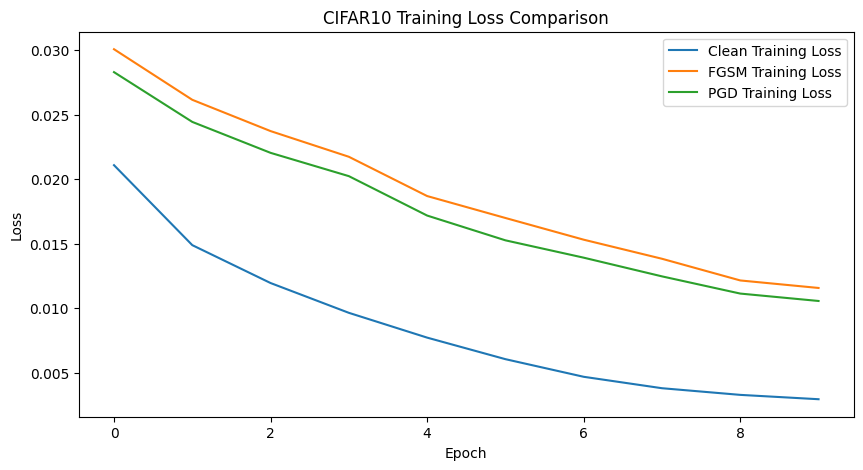

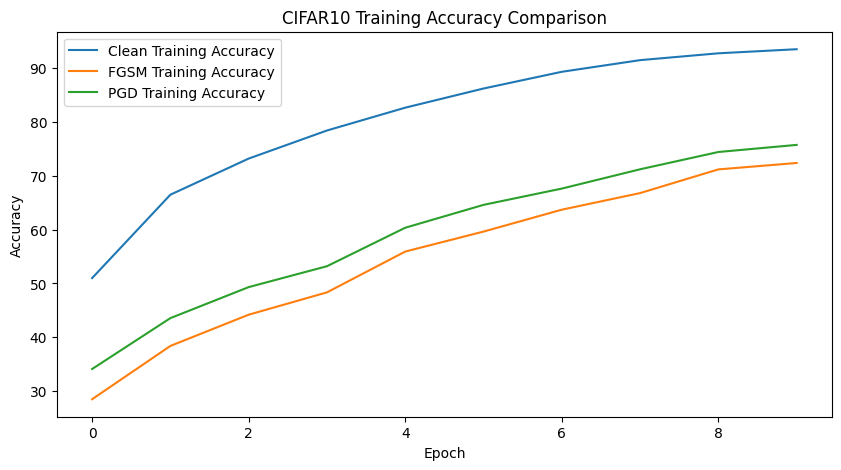

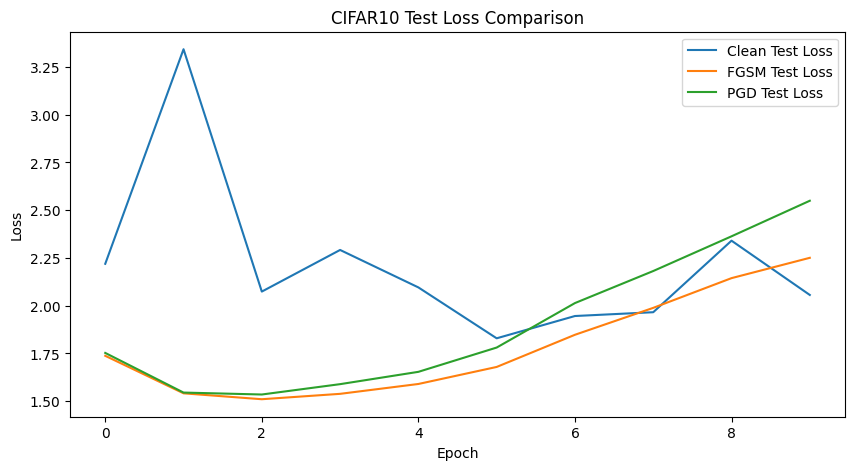

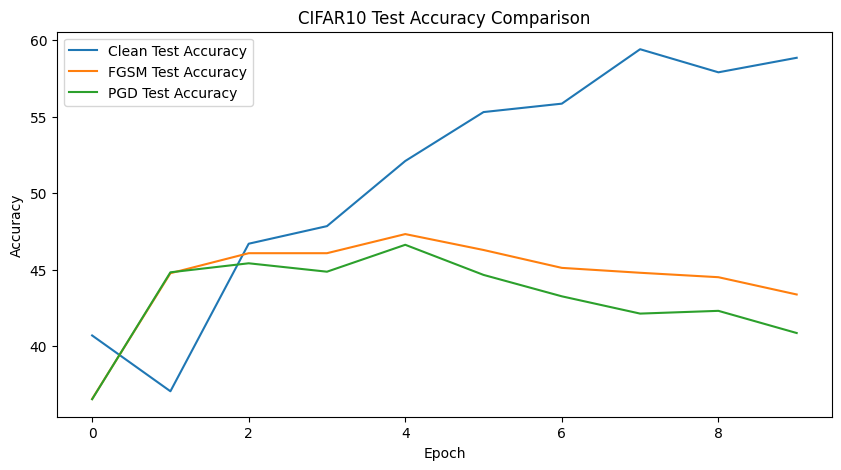

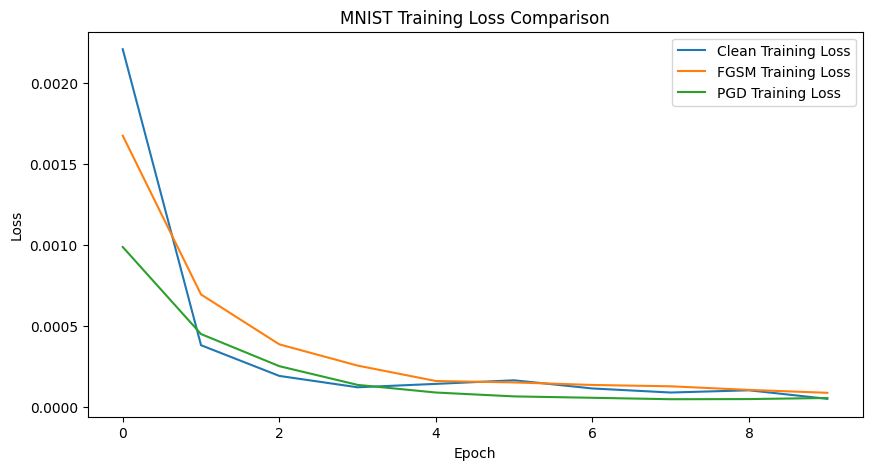

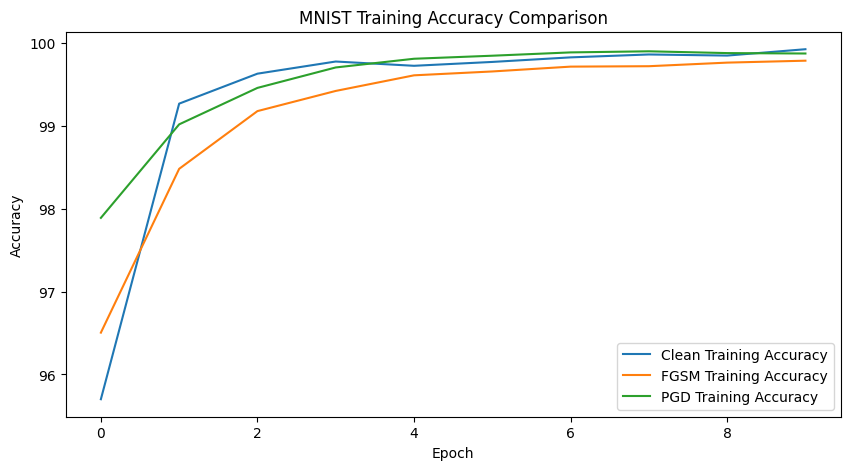

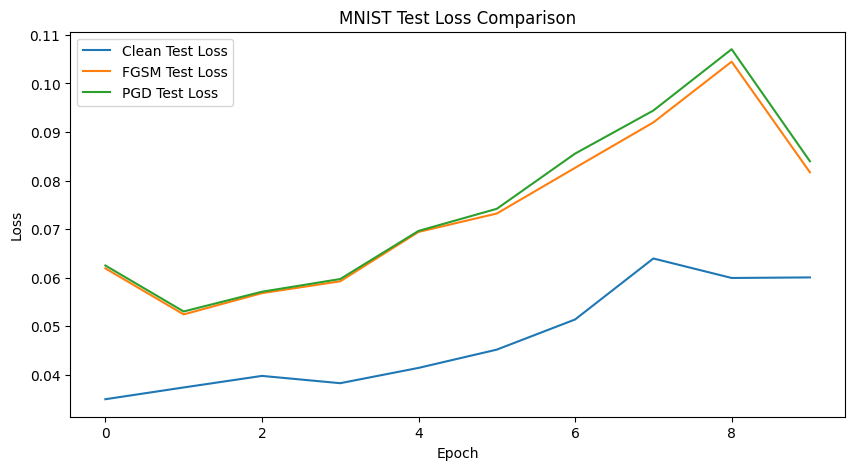

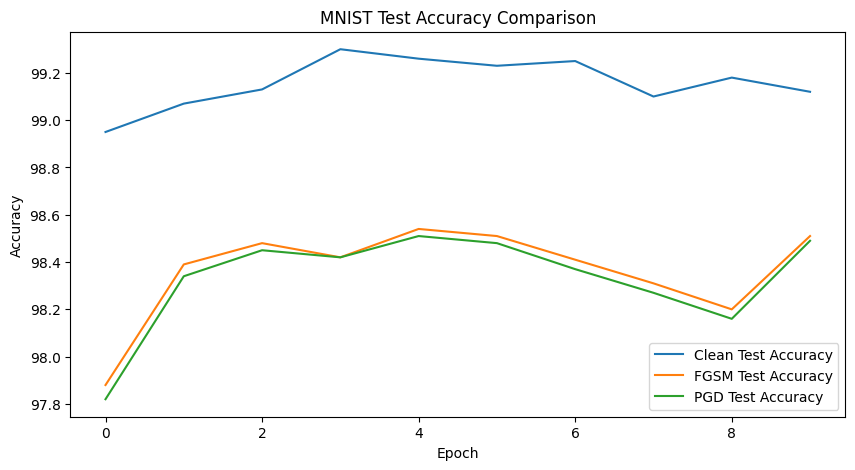

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_cifar, label='Clean Training Loss')
plt.plot(train_losses_cifar_adv, label='FGSM Training Loss')
plt.plot(train_losses_cifar_pgd, label='PGD Training Loss')
plt.title('CIFAR10 Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_cifar, label='Clean Training Accuracy')
plt.plot(train_accuracies_cifar_adv, label='FGSM Training Accuracy')
plt.plot(train_accuracies_cifar_pgd, label='PGD Training Accuracy')
plt.title('CIFAR10 Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_losses_cifar, label='Clean Test Loss')
plt.plot(test_losses_cifar_adv, label='FGSM Test Loss')
plt.plot(test_losses_cifar_pgd, label='PGD Test Loss')
plt.title('CIFAR10 Test Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_accuracies_cifar, label='Clean Test Accuracy')
plt.plot(test_accuracies_cifar_adv, label='FGSM Test Accuracy')
plt.plot(test_accuracies_cifar_pgd, label='PGD Test Accuracy')
plt.title('CIFAR10 Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses_mnist, label='Clean Training Loss')
plt.plot(train_losses_mnist_adv, label='FGSM Training Loss')
plt.plot(train_losses_mnist_pgd, label='PGD Training Loss')
plt.title('MNIST Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_mnist, label='Clean Training Accuracy')
plt.plot(train_accuracies_mnist_adv, label='FGSM Training Accuracy')
plt.plot(train_accuracies_mnist_pgd, label='PGD Training Accuracy')
plt.title('MNIST Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_losses_mnist, label='Clean Test Loss')
plt.plot(test_losses_mnist_adv, label='FGSM Test Loss')
plt.plot(test_losses_mnist_pgd, label='PGD Test Loss')
plt.title('MNIST Test Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_accuracies_mnist, label='Clean Test Accuracy')
plt.plot(test_accuracies_mnist_adv, label='FGSM Test Accuracy')
plt.plot(test_accuracies_mnist_pgd, label='PGD Test Accuracy')
plt.title('MNIST Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
